In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import scipy.stats as ss
import h5py
import seaborn as sns
import time
import os

from scipy.signal import detrend
from scipy.optimize import curve_fit

In [2]:
%matplotlib notebook
%matplotlib inline

In [3]:
# Inputs
full_path ='/mnt/eng_handata/eng_research_handata2/Kyle_Hansen/TonePuff-Rebecca/2982/2982_d9_s1/'
#full_path = '/mnt/eng_handata/Kyle_Hansen/AliEyeBlink/ali25_d5_s1/' #'/mnt/HD_6TB/Kyle/CopyProcessing/' ##'/mnt/eng_research_handata/eng_research_handata2/Kyle/NewTonePuff-Robb/1750/1750_d5_s1/'
#f_name = 'trace_kyleFinalwDoughnut_AllBGs.hdf5'
f_name ='trace_kyleFinal_BinaryVideo.hdf5'
#'trace_KyleFinalwDoughnut.hdf5'
full_path + f_name

'/mnt/eng_handata/eng_research_handata2/Kyle_Hansen/TonePuff-Rebecca/2982/2982_d9_s1/trace_kyleFinal_BinaryVideo.hdf5'

In [4]:
# Initialize HDF5 File
f = h5py.File(full_path+f_name,'r')
f.keys()

<KeysViewHDF5 ['BG10trace', 'BG5trace', 'NPtrace', 'binPuffs', 'binSounds', 'binTrials', 'color', 'eyeTrace', 'file', 'pupilTrace', 'rois', 'trace']>

In [5]:
# Load in Data of Interest
RAWtraces = pd.DataFrame(data=np.array(f['trace']).T)
BG5traces = pd.DataFrame(data=np.array(f['BG5trace']).T)
BG10traces = pd.DataFrame(data=np.array(f['BG10trace']).T)
NPtraces = pd.DataFrame(data=np.array(f['NPtrace']).T)
colors = pd.DataFrame(data=np.array(f['color']).T)
behavior = pd.DataFrame(data=np.array(f['binSounds']).T, columns=['Sounds'])
behavior.loc[:,'Puffs'] = np.array(f['binPuffs']).T
behavior.loc[:,'Trials'] = np.array(f['binTrials']).T
BGtraces = BG10traces
traces = RAWtraces - BGtraces
dt_traces = traces.apply(detrend)
df_traces = (dt_traces - dt_traces.mean()) / dt_traces.mean()
print('RAWTraces: {} \nBGTraces: {} \nColors: {}'.format(RAWtraces.shape, BGtraces.shape, colors.shape))

RAWTraces: (39502, 308) 
BGTraces: (39502, 308) 
Colors: (3, 308)


### Assume Gaussian Baseline, and Determine Trend only on those Points

In [6]:
#Define function used for curve fitting
def linear_func(x, a, b):
    return a*x + b

In [7]:
regress_thresh = 0.05 #Regression Threshold to pick points deviating from linear fit (Percentage of Absolute Amplitude)
N_linfit = int(np.floor(traces.shape[0]*0.5)) #Take first half of data points to determine linear fit

dist_series = traces.apply(lambda x: ss.probplot(x)[0], axis=0)
distributions = pd.DataFrame(data=[item for item in dist_series], columns=['Theoretical', 'Measured'])
distributions.index.name = 'Cell_Number'
param_series = distributions.apply(lambda x: curve_fit(linear_func, x['Theoretical'][:N_linfit], x['Measured'][:N_linfit]), axis=1)
distributions[['Parameters','Covariance']] = pd.DataFrame(data=[item for item in param_series], columns=['Parameters', 'Covariance'])
distributions['Line'] = distributions.apply(lambda x: linear_func(x['Theoretical'], *x['Parameters']), axis=1)
distributions['Difference'] = distributions.apply(lambda x: (x['Measured'] - x['Line']) / (np.nanmax(x['Measured']) - np.nanmin(x['Measured'])), axis=1)
distributions['Deviation_idx'] = distributions.apply(lambda x: np.argmax(x['Difference'][N_linfit:] > regress_thresh)+N_linfit, axis=1)
distributions['Ca_thresh'] = distributions.apply(lambda x: x['Measured'][x['Deviation_idx']], axis=1)
distributions

,Theoretical,Measured,Parameters,Covariance,Line,Difference,Deviation_idx,Ca_thresh
Cell_Number,,,,,,,,
0,"[-4.137611613431475, -3.9293246357941376, -3.8...","[2.6018620803731665, 3.0583748315757475, 3.286...","[4.767178715442996, 29.564100045445755]","[[3.140007551060538e-05, 2.5052464380599814e-0...","[9.839366029125475, 10.832307275622142, 11.374...","[-0.01965135081693084, -0.0211078674038461, -0...",37166,55.476553
1,"[-4.137611613431475, -3.9293246357941376, -3.8...","[10.126313810437068, 12.45732117605155, 12.603...","[6.0212458939917965, 41.03928599216279]","[[1.3645811025815017e-05, 1.0887272984451182e-...","[16.125709053855747, 17.379856162726526, 18.06...","[-0.02062076111148487, -0.016919441694478007, ...",38655,67.801472
2,"[-4.137611613431475, -3.9293246357941376, -3.8...","[21.453856535226578, 21.72721993028233, 23.343...","[6.798364919484638, 57.09377157455838]","[[2.30559545127708e-05, 1.839513035520259e-05]...","[28.96477793135361, 30.380788813308765, 31.153...","[-0.02071649941285914, -0.023868130849670953, ...",37624,86.689540
3,"[-4.137611613431475, -3.9293246357941376, -3.8...","[24.206125133898013, 24.50930684168054, 24.562...","[4.449973267296834, 43.75897034325421]","[[2.432825231781962e-06, 1.941022970453148e-06...","[25.346709273027223, 26.27358075543943, 26.779...","[-0.003977613521213945, -0.006152636647963607,...",37449,65.338789
4,"[-4.137611613431475, -3.9293246357941376, -3.8...","[-22.83501396723409, -21.002394975946572, -20....","[10.30092066557466, 21.528586763816193]","[[1.416727619567945e-05, 1.1303322587055677e-0...","[-21.092622211101798, -18.947074578787266, -17...","[-0.011037991741354055, -0.013020383900369225,...",38028,47.790187
...,...,...,...,...,...,...,...,...
303,"[-4.137611613431475, -3.9293246357941376, -3.8...","[52.486236249029616, 53.971236185000635, 54.81...","[14.114924151306754, 93.42299339821774]","[[0.0001902402760240509, 0.0001517826835187843...","[35.02091930706651, 37.960874198122454, 39.565...","[0.13142912807699567, 0.12048037393909206, 0.1...",39414,140.333536
304,"[-4.137611613431475, -3.9293246357941376, -3.8...","[12.210388342848205, 13.973851352677002, 14.27...","[5.974930025395083, 36.85652125173466]","[[7.996105897546161e-07, 6.379671271517966e-07...","[12.134581389219548, 13.379081505803672, 14.05...","[0.0003571870321028515, 0.0028024352149753563,...",34946,54.645947
305,"[-4.137611613431475, -3.9293246357941376, -3.8...","[-18.227152496786402, -17.732370330254298, -16...","[5.461833312310503, 5.309267409936549]","[[1.1541772015174692e-06, 9.208571233724228e-0...","[-17.28967753370629, -16.152048780726208, -15....","[-0.007804770872184453, -0.013156668800965316,...",37437,20.182028


In [8]:
param_series.loc[0][1]

array([[3.14000755e-05, 2.50524644e-05],
       [2.50524644e-05, 3.13936233e-05]])

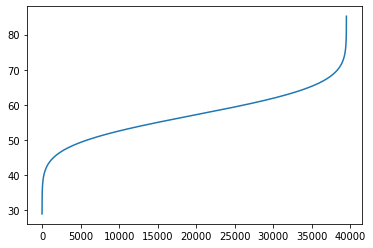

In [9]:
plt.plot(distributions.loc[2,'Line'])

In [10]:
tr_baselines = []
tr_means = []
for c_val in distributions.index:
    tr_baselines.append(distributions.loc[c_val, 'Parameters'][1])
    tr_means.append(traces[c_val].mean())
tr_baselines = np.array(tr_baselines)
tr_means = np.array(tr_means)

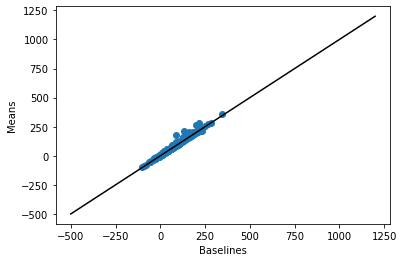

In [11]:
plt.scatter(tr_baselines, tr_means)
plt.xlabel('Baselines')
plt.ylabel('Means')
plt.plot([-500, 1200], [-500, 1200], color='k')

In [12]:
tr_threshes = []
tr_2sds = []
for c_val in distributions.index:
    tr_threshes.append(distributions.loc[c_val, 'Ca_thresh'])
    tr_2sds.append(2*traces[c_val].std()+traces[c_val].mean())
tr_threshes = np.array(tr_threshes)
tr_2sds = np.array(tr_2sds)

Text(0.5, 1.0, '0.02 Threshold')

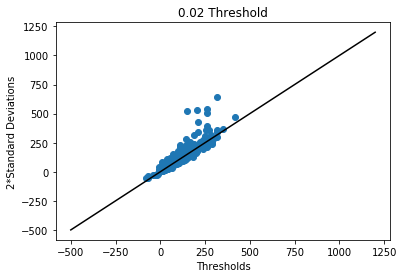

In [13]:
plt.scatter(tr_threshes, tr_2sds)
plt.xlabel('Thresholds')
plt.ylabel('2*Standard Deviations')
plt.plot([-500, 1200], [-500, 1200], color='k')
plt.title('0.02 Threshold')

Text(0.5, 1.0, '0.03 Threshold')

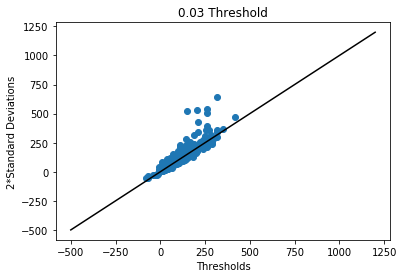

In [14]:
plt.scatter(tr_threshes, tr_2sds)
plt.xlabel('Thresholds')
plt.ylabel('2*Standard Deviations')
plt.plot([-500, 1200], [-500, 1200], color='k')
plt.title('0.03 Threshold')

Text(0.5, 1.0, '0.05 Threshold')

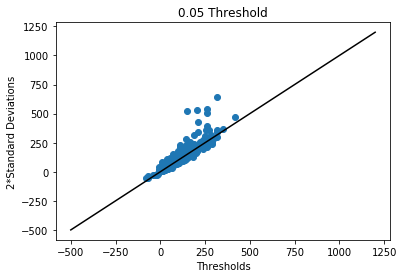

In [15]:
plt.scatter(tr_threshes, tr_2sds)
plt.xlabel('Thresholds')
plt.ylabel('2*Standard Deviations')
plt.plot([-500, 1200], [-500, 1200], color='k')
plt.title('0.05 Threshold')

In [16]:
#Taken from OASIS to Compare
def GetSn(y, range_ff=[0.25, 0.5], method='mean'):
    """
    Estimate noise power through the power spectral density over the range of large frequencies
    Parameters
    ----------
    y : array, shape (T,)
        One dimensional array containing the fluorescence intensities with
        one entry per time-bin.
    range_ff : (1,2) array, nonnegative, max value <= 0.5
        range of frequency (x Nyquist rate) over which the spectrum is averaged
    method : string, optional, default 'mean'
        method of averaging: Mean, median, exponentiated mean of logvalues
    Returns
    -------
    sn : noise standard deviation
    """

    ff, Pxx = scipy.signal.welch(y)
    ind1 = ff > range_ff[0]
    ind2 = ff < range_ff[1]
    ind = np.logical_and(ind1, ind2)
    Pxx_ind = Pxx[ind]
    sn = {
        'mean': lambda Pxx_ind: np.sqrt(np.mean(Pxx_ind / 2)),
        'median': lambda Pxx_ind: np.sqrt(np.median(Pxx_ind / 2)),
        'logmexp': lambda Pxx_ind: np.sqrt(np.exp(np.mean(np.log(Pxx_ind / 2))))
    }[method](Pxx_ind)

    return sn

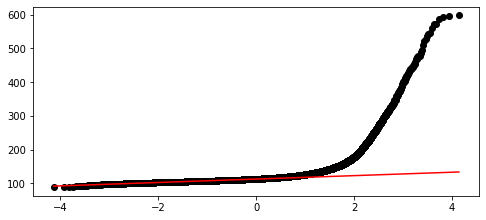

In [17]:
#Extract Cell Plotting Parameters
cell_choice=10#Pick 0, 2, 5, 6, 7, 8, 10
theo = distributions.loc[cell_choice,'Theoretical']
meas = distributions.loc[cell_choice,'Measured']
line = distributions.loc[cell_choice,'Line']
diff = distributions.loc[cell_choice,'Difference']
#Plotting
plt.figure(figsize=(8,16))
plt.subplot(411)
plt.scatter(theo, meas, color='black', label='data')
plt.plot(theo, line, 'r')
plt.savefig('qplot.png',format='png',dpi=1200)
#if to_save_figs: plt.savefig('Cell{}FitParams'.format(cell_choice))

[  5.06480747 112.54685536]


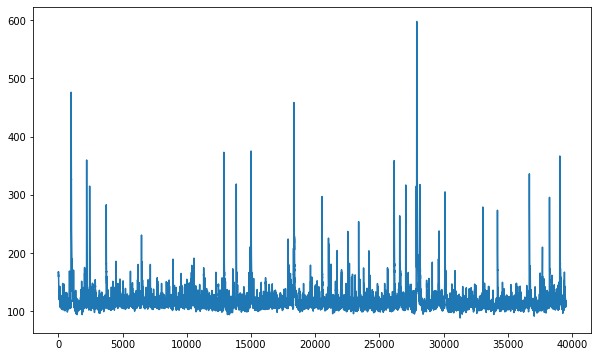

In [21]:
#cell_choice=4
oasis_sn = GetSn(traces.iloc[:,cell_choice],method='mean')
print(distributions.loc[cell_choice, 'Parameters'])
plt.figure(figsize=(10,6))
plt.plot(traces.iloc[:,cell_choice])
plt.savefig('trace.png',format='png',dpi=1200)

In [22]:
distributions.loc[cell_choice,'Ca_thresh'], traces.iloc[:,cell_choice].mean(), traces.iloc[:,cell_choice].mean()+2*traces.iloc[:,cell_choice].std(), distributions.loc[cell_choice,'Parameters'][1]

(146.0497008293711, 119.14544976606149, 170.4741510846888, 112.54685535745651)

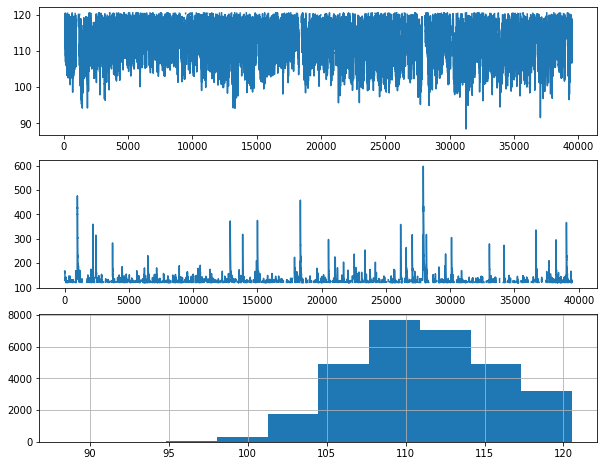

In [23]:
low_traces = traces[traces < distributions.loc[cell_choice,'Parameters'][1]+3*oasis_sn]
high_traces = traces[traces > distributions.loc[cell_choice,'Parameters'][1]+3*oasis_sn]
distributions['Noise_Floor'] = low_traces.std()
#cell_choice=4
plt.figure(figsize=(10,8))
plt.subplot(311)
plt.plot(low_traces.loc[:,cell_choice])
plt.subplot(312)
plt.plot(high_traces.loc[:,cell_choice])
plt.subplot(313)
low_traces.loc[:,cell_choice].hist()
#if to_save_figs: plt.savefig('Cell{}BaselineHistogram'.format(cell_choice))

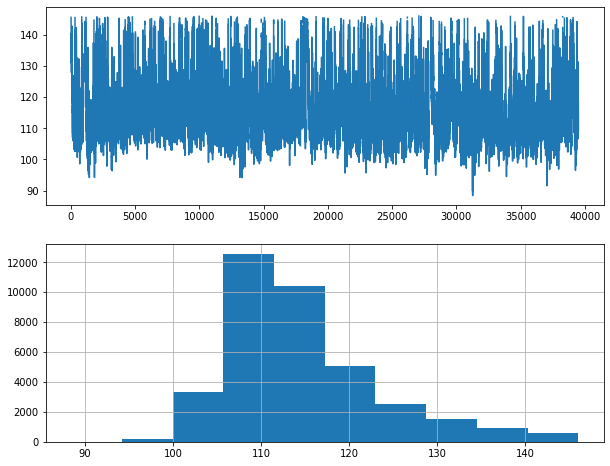

In [24]:
low_traces = traces[traces < distributions['Ca_thresh'].values]
distributions['Noise_Floor'] = low_traces.std()
#cell_choice=4
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot(low_traces.loc[:,cell_choice])
plt.subplot(212)
low_traces.loc[:,cell_choice].hist()
#if to_save_figs: plt.savefig('Cell{}BaselineHistogram'.format(cell_choice))

### Remove Baseline as Line Intercept and Scale by Calcium Threshold

In [25]:
scale_vals = distributions.loc[:,('Parameters', 'Ca_thresh')].transpose(copy=True)
bl_list = []
for row in scale_vals.loc['Parameters',:]:
    bl_list.append(row[1])
scale_vals.loc['Baseline',:] = pd.Series(bl_list)
scale_vals.loc['Unit_Val',:] = scale_vals.loc['Ca_thresh',:] - scale_vals.loc['Baseline',:]
scale_vals.head()

Cell_Number,0,1,2,3,4,5,6,7,8,9,...,298,299,300,301,302,303,304,305,306,307
Parameters,"[4.767178715442996, 29.564100045445755]","[6.0212458939917965, 41.03928599216279]","[6.798364919484638, 57.09377157455838]","[4.449973267296834, 43.75897034325421]","[10.30092066557466, 21.528586763816193]","[7.735903653099711, 53.14298332363116]","[11.892586410724894, 89.83766109314128]","[5.66306110688295, 29.913526894478224]","[7.5206898492703145, 74.97319965380682]","[7.641189253716935, 76.2490142479945]",...,"[7.10450709347317, 44.158661190534126]","[6.54451984648623, 12.712255698833246]","[10.102152551776468, 25.716149401094558]","[19.477097744715223, 32.184889339020806]","[9.314878534410244, 9.976216505769287]","[14.114924151306754, 93.42299339821774]","[5.974930025395083, 36.85652125173466]","[5.461833312310503, 5.309267409936549]","[9.36530896107376, 5.894498511234418]","[8.531455261172141, 57.594941193096105]"
Ca_thresh,55.4766,67.8015,86.6895,65.3388,47.7902,76.0259,124.888,49.3313,101.518,103.329,...,57.3478,40.0631,69.1849,92.4534,36.9724,140.334,54.6459,20.182,29.5149,77.5636
Baseline,29.5641,41.0393,57.0938,43.759,21.5286,53.143,89.8377,29.9135,74.9732,76.249,...,44.1587,12.7123,25.7161,32.1849,9.97622,93.423,36.8565,5.30927,5.8945,57.5949
Unit_Val,25.9125,26.7622,29.5958,21.5798,26.2616,22.8829,35.0506,19.4178,26.545,27.0797,...,13.1892,27.3509,43.4688,60.2685,26.9961,46.9105,17.7894,14.8728,23.6204,19.9686


In [26]:
scaled_traces = (traces - scale_vals.loc['Baseline',:]) / scale_vals.loc['Unit_Val',:]
scaled_traces.head()

,0,1,2,3,4,5,6,7,8,9,...,298,299,300,301,302,303,304,305,306,307
0,0.085599,-0.144971,0.056083,0.561710,-0.429671,0.222909,-0.052173,-0.048061,-0.587220,0.232004,...,1.354642,0.608156,-0.340981,0.138028,0.560264,-0.093052,0.047238,-0.141030,3.101854,1.915563
1,0.187814,-0.232428,0.311351,0.637363,-0.350964,0.360113,0.118125,-0.123610,-0.525528,0.024409,...,1.207554,0.713124,-0.342436,0.107522,0.731435,0.064199,0.470968,-0.063321,2.717677,2.101130
2,0.232895,0.021109,0.397188,0.543980,-0.334181,0.537876,0.190768,0.181519,-0.416138,0.112338,...,1.026182,0.762665,-0.393343,0.070990,0.831281,-0.000960,0.009569,-0.102515,2.347347,1.647201
3,-0.054825,-0.125521,-0.108709,0.507072,-0.546825,0.251139,-0.064307,0.129081,-0.532695,0.095220,...,1.583329,0.555796,-0.419470,0.136049,0.488195,-0.078380,0.542855,0.308051,2.735818,2.091349
4,-0.000385,-0.120380,0.300099,0.557989,-0.499989,0.150201,0.290146,0.291676,-0.435778,0.010856,...,1.100953,0.548527,-0.323229,0.165075,1.140066,0.156081,0.043595,-0.084227,2.432723,1.988561


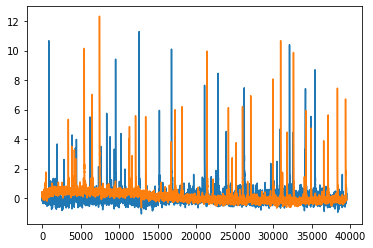

In [27]:
plt.plot(scaled_traces.loc[:,23])
plt.plot(scaled_traces.loc[:,24])

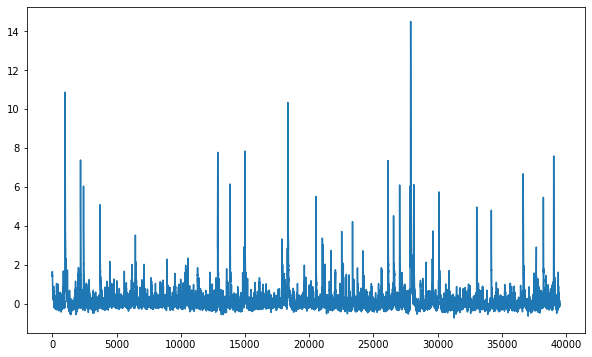

In [28]:
plt.figure(figsize=(10,6))
plt.plot(scaled_traces.loc[:,cell_choice])
plt.savefig('subtracted_trace.png',format='png',dpi=1200)
#if to_save_figs: plt.savefig('Cell{}ScaledTrace'.format(cell_choice))

### Line up over each trial

In [29]:
def findPulses(inputTrace):
    #Find location of onset and offset of pulses
    #inputTrace = 1-D Numpy Array Trace of values assumed to be similar to a train of ttl pulses, where there is a clear onset and offset for each pulse.
    #locationTrace = Pseudo-logical 1-D trace, with 1s at pulse onset, and -1s at pulse offset, and 0s everywhere else
    
    shiftedInput = inputTrace - inputTrace.mean() #Shift to have mean 0 and baseline below 0
    changes = np.sign(shiftedInput) #Find where sign changes
    locationTrace = np.zeros(inputTrace.shape); #Initialize Output
    diffArray = np.diff(changes)
    locationTrace[np.insert(diffArray==2,0,0)] = 1 #Set onsets to 1
    locationTrace[np.insert(diffArray==-2,0,0)] = -1 #Set offsets to -1
    return locationTrace

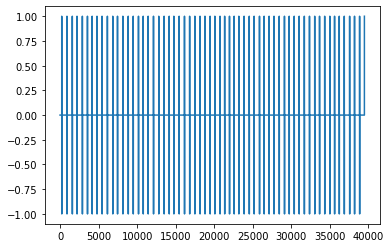

In [30]:
plt.plot(findPulses(behavior['Sounds']))

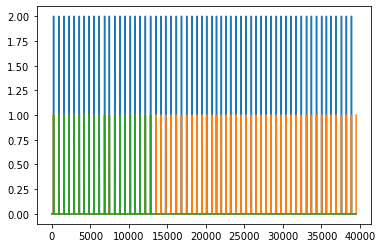

In [31]:
#Example of one trial
plt.plot(behavior['Trials'])
plt.plot(behavior['Sounds'])
plt.plot(behavior['Puffs'])

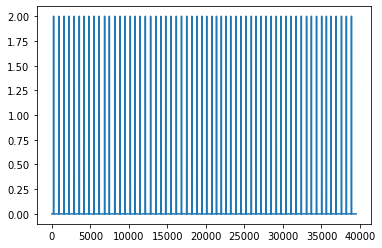

In [32]:
plt.plot(behavior['Trials'])

In [33]:
behavior['SoundPulses'] = findPulses(behavior['Sounds'])
behavior['PuffPulses'] = findPulses(behavior['Puffs'])
behavior['YesMove'] = behavior['Trials']
behavior.loc[behavior['Trials']<0, 'YesMove'] = 0
behavior['NoMove'] = behavior['Trials']
behavior.loc[behavior['Trials']>0, 'NoMove'] = 0